In [1]:
import os
import joblib
import pandas as pd
import shap
import warnings
warnings.filterwarnings("ignore")

c:\Users\User\anaconda3\envs\diabetes_app\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths
CLEAN_DATA_PATH = "../data/processed/diabetes_clean.csv"
MODELS_PATH = "../models"

In [3]:
# Load clean dataset
def load_clean_data(path=CLEAN_DATA_PATH):
    """
    Membaca dataset bersih untuk kebutuhan SHAP analysis.
    """
    df = pd.read_csv(path)
    print("Dataset bersih berhasil dimuat.")
    return df

df = load_clean_data()
X_full_df = df.drop("Outcome", axis=1)
y = df["Outcome"]

Dataset bersih berhasil dimuat.


In [4]:
# Load semua model yang tersimpan
def load_models(models_path=MODELS_PATH):
    """
    Memuat seluruh model .joblib dari folder models.
    """
    model_files = [f for f in os.listdir(models_path) if f.endswith(".joblib")]
    models = {}

    for f in model_files:
        name = f.replace(".joblib", "").replace("_", " ")
        models[name] = joblib.load(os.path.join(models_path, f))

    print(f"{len(models)} model berhasil dimuat.")
    return models

models = load_models()

3 model berhasil dimuat.


In [5]:
# Fungsi Visualisasi SHAP
def shap_visualization_all_classes(model, X_df):
    """
    Visualisasi SHAP untuk seluruh kelas.
    Menampilkan:
    - SHAP summary plot
    - SHAP dependence plot (Glucose & BMI)

    Param:
    model : estimator yang sudah ter-train
    X_df  : dataframe fitur hasil preprocessing
    """

    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_df)
    except Exception as e:
        print(f"SHAP TreeExplainer tidak bisa digunakan: {e}")
        return

    # ---- Jika SHAP berupa list (contoh: Decision Tree binary) ----
    if isinstance(shap_values, list):
        for i, sv in enumerate(shap_values):
            print(f"\n=== SHAP Summary Plot: Class {i} ===")
            shap.summary_plot(sv, X_df, plot_type="bar", max_display=10, show=True)

            print(f"\n=== SHAP Dependence Plot (Class {i}): Glucose ===")
            shap.dependence_plot("Glucose", sv, X_df, show=True)

            print(f"\n=== SHAP Dependence Plot (Class {i}): BMI ===")
            shap.dependence_plot("BMI", sv, X_df, show=True)

    # ---- Jika output multi-class 3D (misal beberapa XGBoost config) ----
    elif len(shap_values.shape) == 3:
        n_classes = shap_values.shape[2]
        for i in range(n_classes):
            sv = shap_values[:, :, i]

            print(f"\n=== SHAP Summary Plot: Class {i} ===")
            shap.summary_plot(sv, X_df, plot_type="bar", max_display=10, show=True)

            print(f"\n=== SHAP Dependence Plot (Class {i}): Glucose ===")
            shap.dependence_plot("Glucose", sv, X_df, show=True)

            print(f"\n=== SHAP Dependence Plot (Class {i}): BMI ===")
            shap.dependence_plot("BMI", sv, X_df, show=True)

    # ---- Default fallback (binary biasa) ----
    else:
        print("\n=== SHAP Summary Plot ===")
        shap.summary_plot(shap_values, X_df, plot_type="bar", max_display=10, show=True)

        print("\n=== SHAP Dependence Plot: Glucose ===")
        shap.dependence_plot("Glucose", shap_values, X_df, show=True)

        print("\n=== SHAP Dependence Plot: BMI ===")
        shap.dependence_plot("BMI", shap_values, X_df, show=True)


===== SHAP Analysis: Decision Tree =====

=== SHAP Summary Plot: Class 0 ===


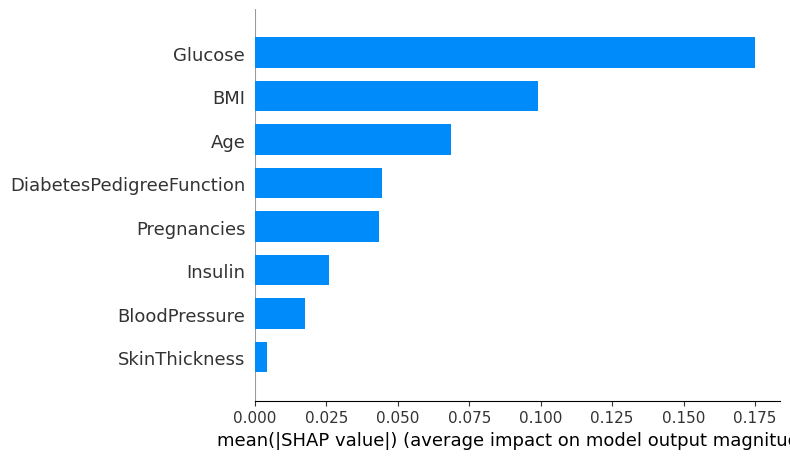


=== SHAP Dependence Plot (Class 0): Glucose ===


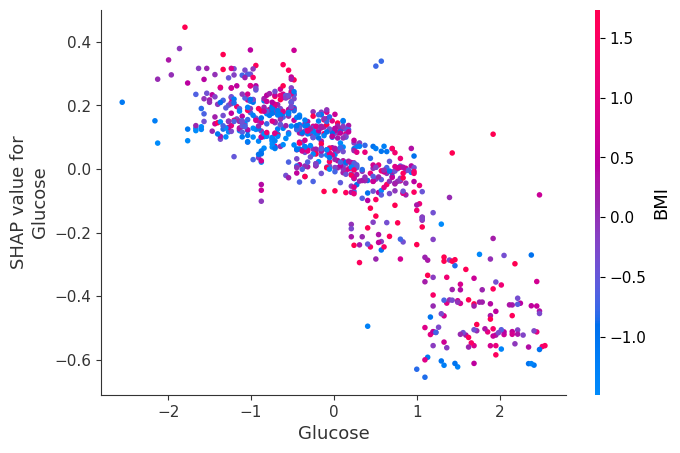


=== SHAP Dependence Plot (Class 0): BMI ===


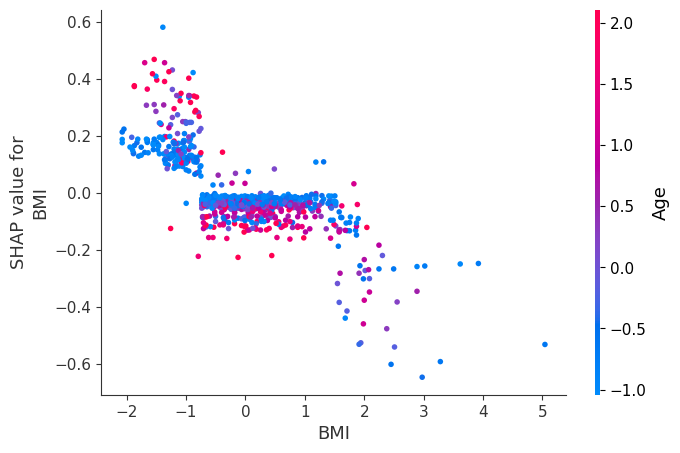


=== SHAP Summary Plot: Class 1 ===


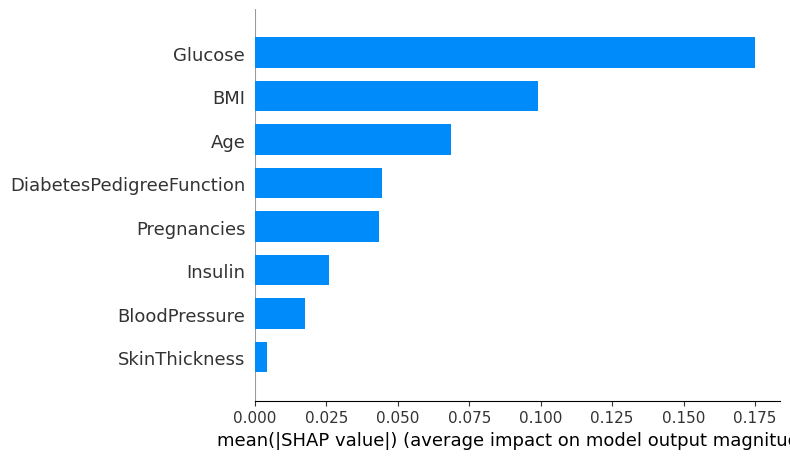


=== SHAP Dependence Plot (Class 1): Glucose ===


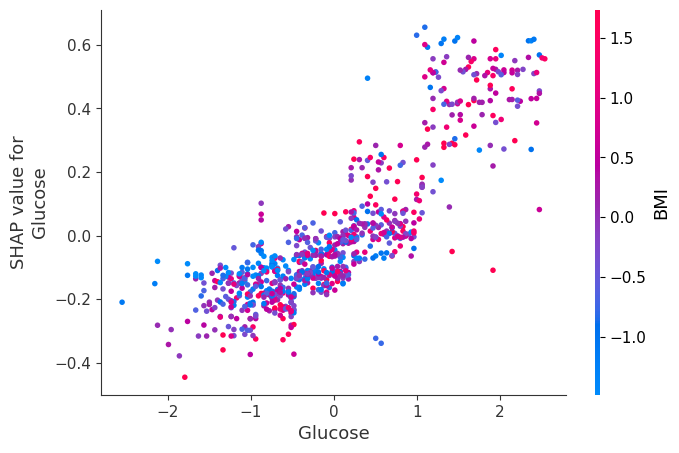


=== SHAP Dependence Plot (Class 1): BMI ===


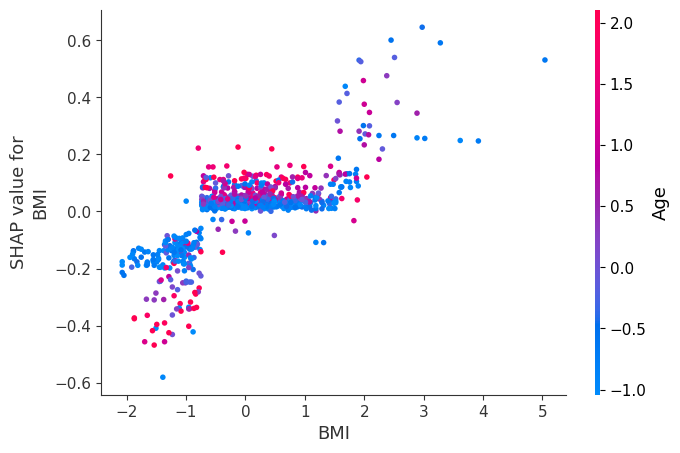


===== SHAP Analysis: XGBoost =====

=== SHAP Summary Plot ===


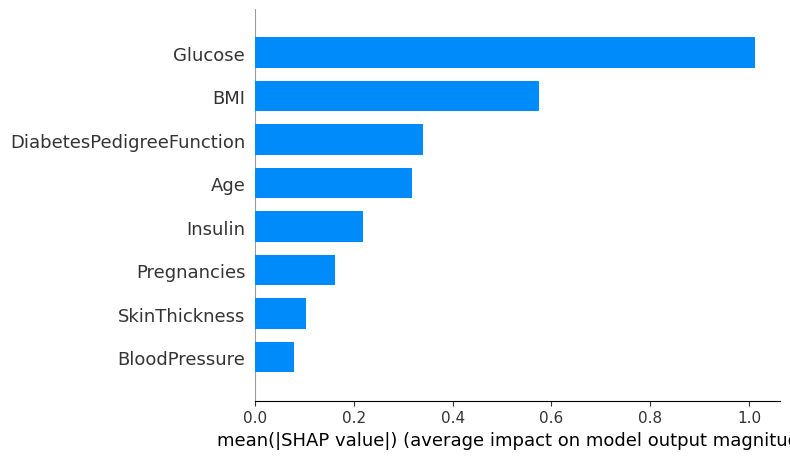


=== SHAP Dependence Plot: Glucose ===


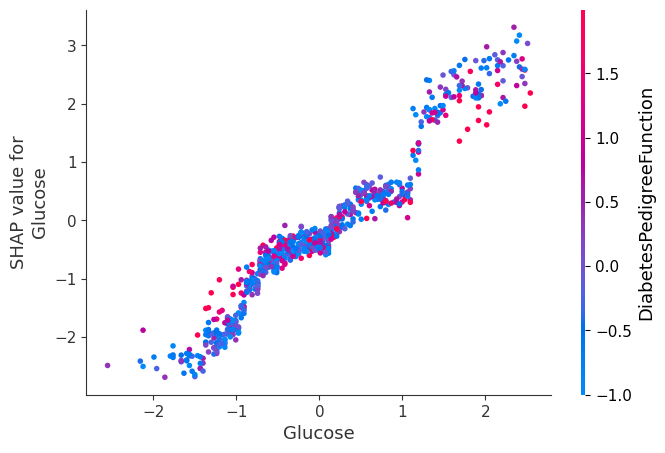


=== SHAP Dependence Plot: BMI ===


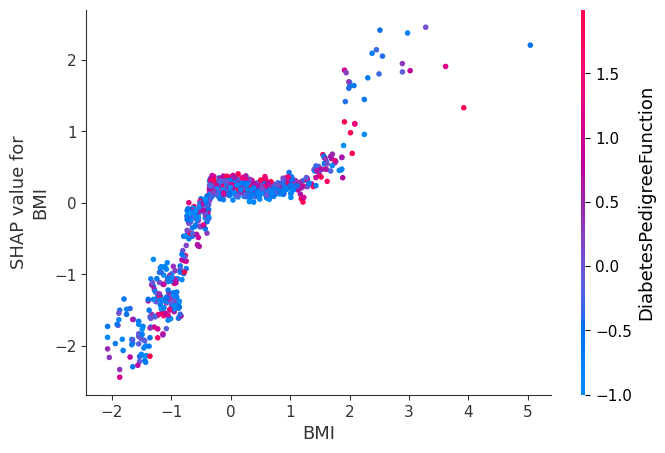

In [6]:
# Tentukan model tree-based untuk SHAP
tree_models = ["Decision Tree", "XGBoost"]

# Jalankan SHAP Analysis
for name in tree_models:
    if name in models:
        print(f"\n===== SHAP Analysis: {name} =====")
        shap_visualization_all_classes(models[name], X_full_df)
    else:
        print(f"Model {name} tidak ditemukan di folder models.")